In [1]:
#SELECTION DEFINITION

NEW_SELECTION = (
    "((Dst_M - D0_M) > 143) & ((Dst_M - D0_M) < 148) & "
    "(K_IPCHI2_OWNPV > 3) & (pi_IPCHI2_OWNPV > 3) & "
    "(K_TRACK_CHI2NDOF < 3.) & (pi_TRACK_CHI2NDOF < 3.) & "
    "(K_PT > 500.) & (pi_PT > 500.) & "
    "(K_hasRich == 1) & (pi_hasRich == 1) & "
    "(mp_TRACK_CHI2NDOF < 3.) & "
    "(mm_TRACK_CHI2NDOF < 3.) & "
    "(mp_isMuon == 1) & (mm_isMuon == 1) & "
    "(mp_PIDmu > 0) & (mm_PIDmu > 0) & "
    "(mp_PT > 250) & (mm_PT > 250) & "
    "(mp_IPCHI2_OWNPV > 3.) & (mm_IPCHI2_OWNPV > 3.) & "
    "(Jpsi_M < 3127) & (Jpsi_M > 3067) & "
    "(Bc_ENDVERTEX_CHI2 < 4.) & "
    "(Bc_IPCHI2_OWNPV < 8.) & "
    "(Bc_DIRA_OWNPV > 0.998) &"
    "(D0_ENDVERTEX_CHI2 < 8.) &"
    "(D0_M > 1835) & (D0_M < 1895) &"
    "(K_ProbNNghost < 0.3) & (pi_ProbNNghost < 0.3) & "
    "(mm_ProbNNghost < 0.3) & (mp_ProbNNghost < 0.3) & "
    "(K_ProbNNk > 0.1) & (pi_ProbNNpi > 0.1) & "
    "(Jpsi_ENDVERTEX_CHI2 < 9.) &"
    "(Dst_ENDVERTEX_CHI2 < 9.) &"
    "(abs(Dst_M - 2010.) < 30.) &"
    "(Dst_PT > 2500.) &"
    "(pi_soft_TRACK_CHI2NDOF < 3.) &"
    "(pi_soft_TRACK_GhostProb < 0.3)"
)

In [2]:

#IMPORTING LIBRARIES
import uproot
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numpy import mean
from numpy import std
import zfit

from xgboost import XGBClassifier, callback, plot_importance
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler
import pickle
import optuna
import joblib
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

/afs/cern.ch/user/k/ktrofimi/.venv/lib64/python3.9/site-packages/zfit/__init__.py:60: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn(
2025-03-11 15:22:53.105493: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741702977.251422  786605 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741702978.212543  786605 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/afs/cern.ch/user/k/ktrofimi/.venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarni

In [3]:
#LOADING DATASET

files_simu = [
    '/eos/user/f/facglase/tuples/Bc2JpsiDst/mc/Bc2JpsiDst_Kpi/2011_MagDown.root',
    '/eos/user/f/facglase/tuples/Bc2JpsiDst/mc/Bc2JpsiDst_Kpi/2011_MagUp.root',
    '/eos/user/f/facglase/tuples/Bc2JpsiDst/mc/Bc2JpsiDst_Kpi/2012_MagDown.root',
    '/eos/user/f/facglase/tuples/Bc2JpsiDst/mc/Bc2JpsiDst_Kpi/2012_MagUp.root',
    '/eos/user/f/facglase/tuples/Bc2JpsiDst/mc/Bc2JpsiDst_Kpi/2015_MagDown.root',
    '/eos/user/f/facglase/tuples/Bc2JpsiDst/mc/Bc2JpsiDst_Kpi/2015_MagUp.root',
    '/eos/user/f/facglase/tuples/Bc2JpsiDst/mc/Bc2JpsiDst_Kpi/2016_MagDown.root',
    '/eos/user/f/facglase/tuples/Bc2JpsiDst/mc/Bc2JpsiDst_Kpi/2016_MagUp.root',
    '/eos/user/f/facglase/tuples/Bc2JpsiDst/mc/Bc2JpsiDst_Kpi/2017_MagDown.root',
    # '/eos/user/f/facglase/tuples/Bc2JpsiDst/mc/Bc2JpsiDst_Kpi/2017_MagUp.root',
    '/eos/user/f/facglase/tuples/Bc2JpsiDst/mc/Bc2JpsiDst_Kpi/2018_MagDown.root',
    '/eos/user/f/facglase/tuples/Bc2JpsiDst/mc/Bc2JpsiDst_Kpi/2018_MagUp.root',
]

files_real_data = [
    '/eos/user/f/facglase/tuples/Bc2JpsiDst/data/Kpi/2011_MagDown.root',
    '/eos/user/f/facglase/tuples/Bc2JpsiDst/data/Kpi/2011_MagUp.root',
    '/eos/user/f/facglase/tuples/Bc2JpsiDst/data/Kpi/2012_MagDown.root',
    '/eos/user/f/facglase/tuples/Bc2JpsiDst/data/Kpi/2012_MagUp.root',
    # '/eos/user/f/facglase/tuples/Bc2JpsiDst/data/Kpi/2015_MagDown.root',
    '/eos/user/f/facglase/tuples/Bc2JpsiDst/data/Kpi/2015_MagUp.root',
    # '/eos/user/f/facglase/tuples/Bc2JpsiDst/data/Kpi/2016_MagDown.root',
    '/eos/user/f/facglase/tuples/Bc2JpsiDst/data/Kpi/2016_MagUp.root',
    '/eos/user/f/facglase/tuples/Bc2JpsiDst/data/Kpi/2017_MagDown.root',
    '/eos/user/f/facglase/tuples/Bc2JpsiDst/data/Kpi/2017_MagUp.root',
    '/eos/user/f/facglase/tuples/Bc2JpsiDst/data/Kpi/2018_MagDown.root',
    '/eos/user/f/facglase/tuples/Bc2JpsiDst/data/Kpi/2018_MagUp.root',
]
simu_data = uproot.concatenate(files_simu, cut = f"{NEW_SELECTION} & (Bc_BKGCAT == 0)", library='pd')
real_data = uproot.concatenate(files_real_data, cut = f"{NEW_SELECTION} & ((Bc_FullDTF_M < 6250.) | (Bc_FullDTF_M > 6300.))", library='pd')
real_data['delta_mass'] = real_data['Dst_M'] - real_data['D0_M']
simu_data['delta_mass'] = simu_data['Dst_M'] - simu_data['D0_M']


/tmp/ktrofimi/ipykernel_786605/2247319782.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  real_data['delta_mass'] = real_data['Dst_M'] - real_data['D0_M']
/tmp/ktrofimi/ipykernel_786605/2247319782.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  simu_data['delta_mass'] = simu_data['Dst_M'] - simu_data['D0_M']


In [4]:
simu_data["min_mm_mp_PT"] = simu_data[["mm_PT", "mp_PT"]].min(axis=1)
simu_data["max_mm_mp_PT"] = simu_data[["mm_PT", "mp_PT"]].max(axis=1)

simu_data["min_K_pi_PT"] = simu_data[["K_PT", "pi_PT"]].min(axis=1)
simu_data["max_K_pi_PT"] = simu_data[["K_PT", "pi_PT"]].max(axis=1)

real_data["min_mm_mp_PT"] = real_data[["mm_PT", "mp_PT"]].min(axis=1)
real_data["max_mm_mp_PT"] = real_data[["mm_PT", "mp_PT"]].max(axis=1)

real_data["min_K_pi_PT"] = real_data[["K_PT", "pi_PT"]].min(axis=1)
real_data["max_K_pi_PT"] = real_data[["K_PT", "pi_PT"]].max(axis=1)


/tmp/ktrofimi/ipykernel_786605/789072450.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  simu_data["min_mm_mp_PT"] = simu_data[["mm_PT", "mp_PT"]].min(axis=1)
/tmp/ktrofimi/ipykernel_786605/789072450.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  simu_data["max_mm_mp_PT"] = simu_data[["mm_PT", "mp_PT"]].max(axis=1)
/tmp/ktrofimi/ipykernel_786605/789072450.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joini

In [5]:
#DEFINING TRAINING FEATURES

feature_columns = [

    'min_mm_mp_PT',
    'max_mm_mp_PT',
    'Bc_ENDVERTEX_CHI2',
    'Bc_IPCHI2_OWNPV',

    'Bc_FD_OWNPV',
    'Jpsi_FD_ORIVX',
    'D0_FD_ORIVX',
    'min_K_pi_PT'
    ]

#PREPARING DATASET
# Separate features and labels
X_simu = simu_data[feature_columns]
y_simu = np.ones(len(simu_data))  # Label: 1 for simulation data

X_real = real_data[feature_columns]
y_real = np.zeros(len(real_data))  # Label: 0 for real data

# Combine features and labels
X_all = pd.concat([X_simu, X_real], ignore_index=True)  
y_all = np.concatenate([y_simu, y_real])  


print(f"SIMULATION set size: {X_simu.shape}")
print(f"REAL DATA set size: {X_real.shape}")
print(X_simu)
print(X_real)

SIMULATION set size: (33960, 8)
REAL DATA set size: (1316, 8)
        min_mm_mp_PT  max_mm_mp_PT  Bc_ENDVERTEX_CHI2  Bc_IPCHI2_OWNPV  \
8        4860.809836   8479.198373           0.455585         0.403059   
9        1063.445998   2344.609777           0.870358         1.258164   
14       1394.540077   2326.615417           2.228113         3.084171   
16        777.685778   3085.253679           1.890762         1.379406   
17       1413.112193   1719.832505           1.307090         2.768852   
...              ...           ...                ...              ...   
117065   1458.977804   4716.884499           0.171022         1.246758   
117070   1189.963495   3733.743162           0.454725         1.209113   
117077    610.788920   2538.447572           0.153204         0.617149   
117084   5131.196261   8271.353894           0.303271         1.108801   
117087    733.787919   3017.353463           0.799480         0.024631   

        Bc_FD_OWNPV  Jpsi_FD_ORIVX  D0_FD_ORIVX  

In [39]:
# #IMPLEMENTING OPTUNA TO FIND THE BEST MODEL another one

# X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=76)

# print(f"Training set size: {X_train.shape}")
# print(f"Test set size: {X_test.shape}")

# def objective(trial):
#     params = {
#         'n_estimators': trial.suggest_int('n_estimators', 10, 500),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
#         'max_depth': trial.suggest_int('max_depth', 2, 20)
#     }
#     model_optuna = XGBClassifier(**params, random_state=52, eval_metric="logloss")
#     model_optuna.fit(X_train, y_train)
#     preds = model_optuna.predict_proba(X_test)[:, 1]
#     score = roc_auc_score(y_test, preds)
#     if not hasattr(objective, 'best_score') or score > objective.best_score:
#         objective.best_score = score
#         objective.best_model = model_optuna 
#     return score

# # Optimize
# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=1)
# best_model = objective.best_model
# joblib.dump(best_model, "best_optuna_model.pkl")

# print("Best parameters:", study.best_params)
# print("Best ROC-AUC Score:", study.best_value)
# print("Best model saved as 'best_optuna_model.pkl'")


Training set size: (29539, 7)
Test set size: (7385, 7)


[I 2025-02-18 09:44:12,863] A new study created in memory with name: no-name-d75a8c43-a52b-4e9d-bceb-20f2340369e3
[I 2025-02-18 09:44:43,679] Trial 0 finished with value: 0.9158011512297227 and parameters: {'n_estimators': 394, 'learning_rate': 0.050143056380727594, 'max_depth': 3}. Best is trial 0 with value: 0.9158011512297227.


Best parameters: {'n_estimators': 394, 'learning_rate': 0.050143056380727594, 'max_depth': 3}
Best ROC-AUC Score: 0.9158011512297227
Best model saved as 'best_optuna_model.pkl'


In [6]:
#TRAINING MODEL WITH K-FOLD AND EARLY STOPPING another one
from sklearn.preprocessing import LabelEncoder
n_folds = 5
fold_accuracies = []

kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=11)

# Load Optuna-saved model parameters
with open("best_optuna_model_new.pkl", "rb") as file:
    best_model_params = pickle.load(file)
try:
    print(type(best_model_params))  # Debugging step
    print(best_model_params) 
    if isinstance(best_model_params, XGBClassifier):
        best_model_params = best_model_params.get_params()  # Extract parameters from model
    elif not isinstance(best_model_params, dict):
        raise TypeError(f"Unexpected type for best_model_params: {type(best_model_params)}")

    elif not isinstance(best_model_params, dict):
        raise TypeError("Unexpected type for best_model_params:", type(best_model_params))


except ImportError as e:
    print("ImportError occurred:", e)

# Ensure parameters are valid for XGBClassifier
if hasattr(best_model_params, 'get_params'):
    best_model_params = best_model_params.get_params()


best_model_params.update({
    'random_state': 51, 
    'eval_metric': 'logloss' ,
    'early_stopping_rounds': 20 
})

classif_list = []
# Perform k-fold cross-validation
for fold, (train_index, val_index) in enumerate(kf.split(X_all, y_all)):
    print(f"Processing Fold {fold + 1}/{n_folds}...")
    # Initialize the model with the best parameters
    model_es = XGBClassifier(**best_model_params)
    # Split the data using iloc for pandas DataFrame compatibility
    X_train, X_val = X_all.iloc[train_index], X_all.iloc[val_index]
    y_train, y_val = y_all[train_index], y_all[val_index]
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    

    # Fit the model with early stopping
    model_es.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )
    classif_list.append(model_es)
    # Evaluate the model on the validation set
    y_pred = model_es.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    fold_accuracies.append(acc)
    print(f"Fold {fold + 1} Accuracy: {acc:.4f}")

mean_accuracy = np.mean(fold_accuracies)
print(f"\nMean Cross-Validation Accuracy: {mean_accuracy:.4f}")

model_es.save_model("best_kfold_early_stopping_model.json")


<class 'xgboost.sklearn.XGBClassifier'>
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.24329302219140753, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=230, n_jobs=None,
              num_parallel_tree=None, random_state=71, ...)
Processing Fold 1/5...
Fold 1 Accuracy: 0.9657
Processing Fold 2/5...
Fold 2 Accuracy: 0.9674
Processing Fold 3/5...
Fold 3 Accuracy: 0.9675
Processing Fold 4/5...
Fold 4 Acc

In [7]:
#ACCURACY

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=92)
# Predict on the test set
y_pred = classif_list[1].predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Generate a classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.97
Classification Report:
              precision    recall  f1-score   support

         0.0       0.74      0.31      0.44       265
         1.0       0.97      1.00      0.98      6791

    accuracy                           0.97      7056
   macro avg       0.86      0.65      0.71      7056
weighted avg       0.97      0.97      0.96      7056



2025-03-11 15:29:10.049634: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/tmp/ktrofimi/ipykernel_786605/2417195458.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  SIGNAL = float(exp_pdf_extended.ext_integrate(limits=(6250, 6300)).numpy())


Best threshold: 0.990 with significance: 3.926


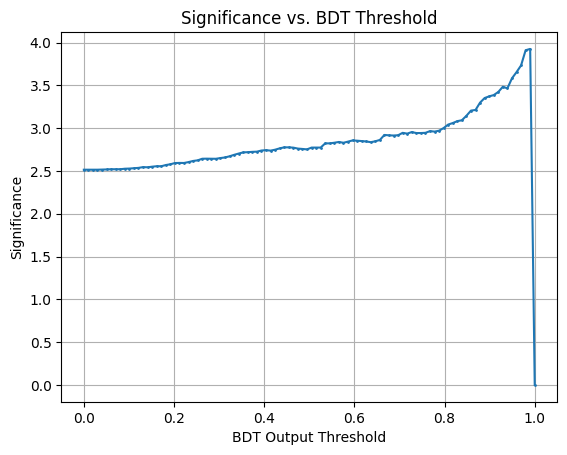

In [8]:
real_data_predictions = classif_list[1].predict_proba(X_real)[:, 1]
real_data_filtered = real_data[real_data_predictions > 0.85]

#SIGNIFICANCE _ BDT PLOT
bdt_thresholds = np.linspace(0.0, 1.0, 100)  
significance_values = []

max_significance = 0.0
best_threshold = None

for threshold in bdt_thresholds:
    real_data_filtered = real_data[real_data_predictions > threshold]
    mass_values = real_data_filtered['Bc_FullDTF_M'].values
    mass_values_fit = mass_values[mass_values > 6300]

    if len(mass_values_fit) == 0:
        significance_values.append(0.0)
        continue

    mass_space_fit = zfit.Space("Bc_FullDTF_M", limits=(6300, 7000))
    data_fit = zfit.Data.from_numpy(obs=mass_space_fit, array=mass_values_fit)

    lambda_param = zfit.Parameter("lambda", -0.002, -0.005, -0.0001) 
    N_bkg = zfit.Parameter("N_bkg", max(len(mass_values_fit), 1), 0, 1e6)  

    exp_pdf = zfit.pdf.Exponential(lambda_param, obs=mass_space_fit)
    exp_pdf_extended = exp_pdf.create_extended(N_bkg)
    nll = zfit.loss.ExtendedUnbinnedNLL(model=exp_pdf_extended, data=data_fit)
    minimizer = zfit.minimize.Minuit()

    try:
        result = minimizer.minimize(nll)
        SIGNAL = float(exp_pdf_extended.ext_integrate(limits=(6250, 6300)).numpy())
    except (zfit.minimizers.strategy.FailMinimizeNaN, RuntimeError):
        SIGNAL = 0.0  

    S = 17.4 
    significance = S / np.sqrt(S + SIGNAL) if SIGNAL > 0 else 0.0
    significance_values.append(significance)

    if significance > max_significance:
        max_significance = significance
        best_threshold = threshold

print(f"Best threshold: {best_threshold:.3f} with significance: {max_significance:.3f}")

plt.plot(bdt_thresholds, significance_values, marker='o', linestyle='-', markersize = 1)
plt.xlabel("BDT Output Threshold")
plt.ylabel("Significance")
plt.title("Significance vs. BDT Threshold")
plt.grid()
plt.show()

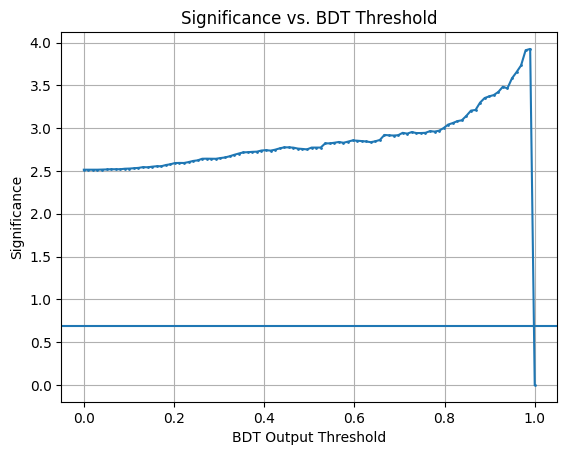

In [18]:
plt.plot(bdt_thresholds, significance_values, marker='o', linestyle='-', markersize = 1)
plt.axhline(0.69)
plt.xlabel("BDT Output Threshold")
plt.ylabel("Significance")
plt.title("Significance vs. BDT Threshold")
plt.grid()
plt.show()

FitResult of
<ExtendedUnbinnedNLL model=[<zfit.<class 'zfit.models.basic.Exponential'>  params=[lambda, lambda]] data=[<zfit.Data: Data obs=('Bc_FullDTF_M',) shape=(40, 1)>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤══════════════════════════════╕
│  valid  │  converged  │  param at limit  │   edm   │   approx. fmin (full | opt.) │
╞═════════╪═════════════╪══════════════════╪═════════╪══════════════════════════════╡
│  True   │    True     │      False       │ 2.6e-05 │            262.74 |  10242.2 │
╘═════════╧═════════════╧══════════════════╧═════════╧══════════════════════════════╛

Parameters
name      value  (rounded)    at limit
------  ------------------  ----------
N_bkg              40.0179       False
lambda         -0.00162314       False
Fitted lambda: -0.001623
Fitted background yield: 40.02
background events in a signal region: [4.98282623]
SIGNIFICANCE: [4.02053161]
Len of background: 60.00


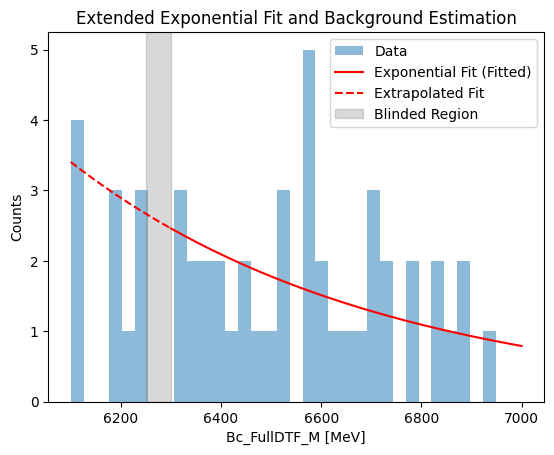

In [17]:
real_data_predictions = classif_list[1].predict_proba(X_real)[:, 1]
cut = 0.96
real_data_filtered = real_data[real_data_predictions > cut]

#SUPER CORRECT


mass_values = real_data_filtered['Bc_FullDTF_M'].values
mass_values_fit = mass_values[mass_values > 6300]

mass_space_fit = zfit.Space("Bc_FullDTF_M", limits=(6300, 7000))
data_fit = zfit.Data.from_numpy(obs=mass_space_fit, array=mass_values_fit)

lambda_param = zfit.Parameter("lambda", -0.002, -0.005, -0.0001) 
N_bkg = zfit.Parameter("N_bkg", len(mass_values_fit), 0, 1e6)  

exp_pdf = zfit.pdf.Exponential(lambda_param, obs=mass_space_fit)
exp_pdf_extended = exp_pdf.create_extended(N_bkg)

nll = zfit.loss.ExtendedUnbinnedNLL(model=exp_pdf_extended, data=data_fit)
minimizer = zfit.minimize.Minuit()
result = minimizer.minimize(nll)
print(result)

lambda_fit = lambda_param.numpy()
N_bkg_fit = N_bkg.numpy()
print(f"Fitted lambda: {lambda_fit:.6f}")
print(f"Fitted background yield: {N_bkg_fit:.2f}")

nbins = 35
bins = np.linspace(6100, 7000, nbins)
bin_width = (7000 - 6100) / nbins

hist, bin_edges = np.histogram(mass_values, bins=nbins)
plt.hist(mass_values, bins=nbins, alpha=0.5, range = (6100, 7000), label="Data")

x_fit = np.linspace(6100, 7000, 1000)
y_fit = exp_pdf_extended.pdf(x_fit, norm=mass_space_fit).numpy() * N_bkg_fit * bin_width

mask_fit = x_fit >= 6300
mask_extrap = x_fit < 6300

plt.plot(x_fit[mask_fit], y_fit[mask_fit], label="Exponential Fit (Fitted)", color="red")
plt.plot(x_fit[mask_extrap], y_fit[mask_extrap], '--', color="red", label="Extrapolated Fit")
plt.axvspan(6250, 6300, color="gray", alpha=0.3, label="Blinded Region")

SIGNAL = exp_pdf_extended.ext_integrate(limits=(6250, 6300)).numpy()

S = 21*cut
significance = S / np.sqrt(S + SIGNAL)

print(f"background events in a signal region: {SIGNAL}")
print(f"SIGNIFICANCE: {significance}")
print(f"Len of background: {len(mass_values_fit):.2f}")

plt.xlabel("Bc_FullDTF_M [MeV]")
plt.ylabel("Counts")
plt.legend()
plt.title(f"Extended Exponential Fit and Background Estimation")
plt.show()


/tmp/ktrofimi/ipykernel_786605/3764863203.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  SIGNAL = float(exp_pdf_extended.ext_integrate(limits=(6250, 6300)).numpy())


Best threshold: 0.960 with significance: 3.770
BDT Efficiency at best threshold: 0.872


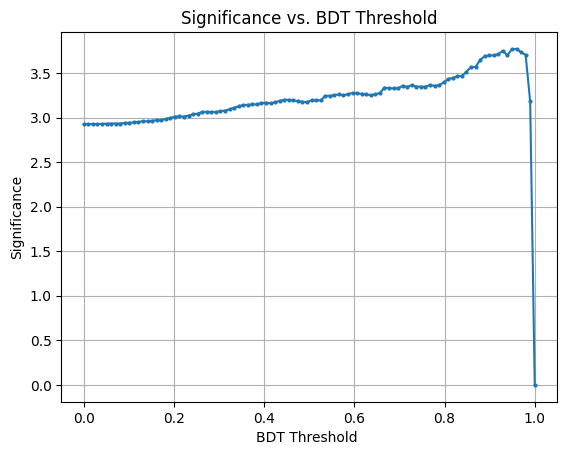

In [19]:
bdt_thresholds = np.linspace(0.0, 1.0, 100)  
significance_values = []
bdt_efficiencies = []  

max_significance = 0.0
best_threshold = None
best_efficiency = None

train_bdt_scores_simu = classif_list[1].predict_proba(X_simu)[:, 1]  

for threshold in bdt_thresholds:

    real_data_filtered = real_data[real_data_predictions > threshold]
    mass_values = real_data_filtered["Bc_FullDTF_M"].values
    mass_values_fit = mass_values[mass_values > 6300]

    signal_retained = np.sum(train_bdt_scores_simu > threshold)  
    bdt_efficiency = signal_retained / len(X_simu) if len(X_simu) > 0 else 0  
    bdt_efficiencies.append(bdt_efficiency)

    if len(mass_values_fit) == 0:
        significance_values.append(0.0)
        continue

    mass_space_fit = zfit.Space("Bc_FullDTF_M", limits=(6300, 7000))
    data_fit = zfit.Data.from_numpy(obs=mass_space_fit, array=mass_values_fit)

    lambda_param = zfit.Parameter("lambda", -0.002, -0.005, -0.0001) 
    N_bkg = zfit.Parameter("N_bkg", max(len(mass_values_fit), 1), 0, 1e6)  

    exp_pdf = zfit.pdf.Exponential(lambda_param, obs=mass_space_fit)
    exp_pdf_extended = exp_pdf.create_extended(N_bkg)
    nll = zfit.loss.ExtendedUnbinnedNLL(model=exp_pdf_extended, data=data_fit)
    minimizer = zfit.minimize.Minuit()

    try:
        result = minimizer.minimize(nll)
        SIGNAL = float(exp_pdf_extended.ext_integrate(limits=(6250, 6300)).numpy())
    except (zfit.minimizers.strategy.FailMinimizeNaN, RuntimeError):
        SIGNAL = 0.0  

    S = 21 * bdt_efficiency  
    significance = S / np.sqrt(S + SIGNAL) if SIGNAL > 0 else 0.0
    significance_values.append(significance)

    if significance > max_significance:
        max_significance = significance
        best_threshold = threshold
        best_efficiency = bdt_efficiency  


print(f"Best threshold: {best_threshold:.3f} with significance: {max_significance:.3f}")
print(f"BDT Efficiency at best threshold: {best_efficiency:.3f}")

plt.plot(bdt_thresholds, significance_values, marker='o', linestyle='-', markersize=2)
plt.xlabel("BDT Threshold ")
plt.ylabel("Significance")
plt.title("Significance vs. BDT Threshold")
plt.grid()
plt.show()

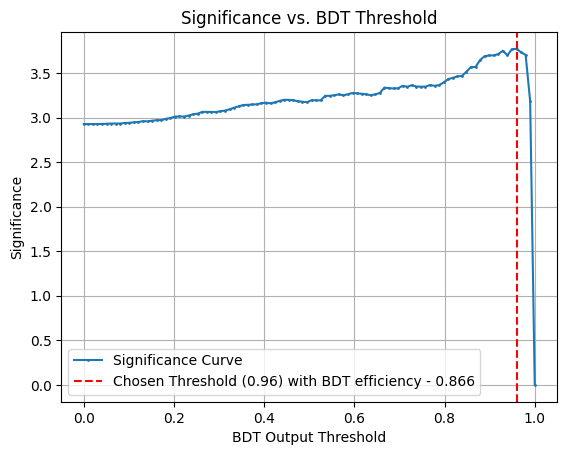

In [20]:
plt.plot(bdt_thresholds, significance_values, marker='o', linestyle='-', markersize=1, label="Significance Curve")

# Highlight the threshold 0.96
plt.axvline(0.96, color="red", linestyle="--", label="Chosen Threshold (0.96) with BDT efficiency - 0.866")

# Find the significance value at threshold 0.96
chosen_significance = 0.866  # Given value


plt.xlabel("BDT Output Threshold")
plt.ylabel("Significance")
plt.title("Significance vs. BDT Threshold")
plt.legend()
plt.grid()
plt.show()


In [ ]:
plt.plot(bdt_efficiencies, bdt_thresholds, marker='o', linestyle='-', markersize=2)
plt.xlabel("BDT Efficiency (signal) ")
plt.ylabel("BDT thresholds")
plt.title("BDT thresholds vs. BDT Efficiency")
plt.grid()
plt.show()

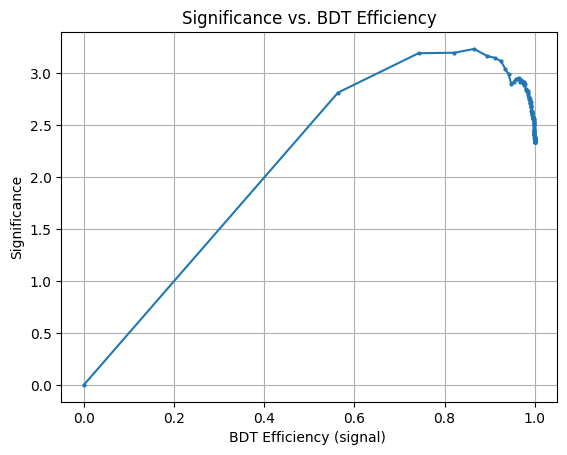

In [17]:
plt.plot(bdt_efficiencies, significance_values, marker='o', linestyle='-', markersize=2)
plt.xlabel("BDT Efficiency (signal) ")
plt.ylabel("Significance")
plt.title("Significance vs. BDT Efficiency")
plt.grid()
plt.show()

Not-filtered data size: 1316
Filtered data size: 212


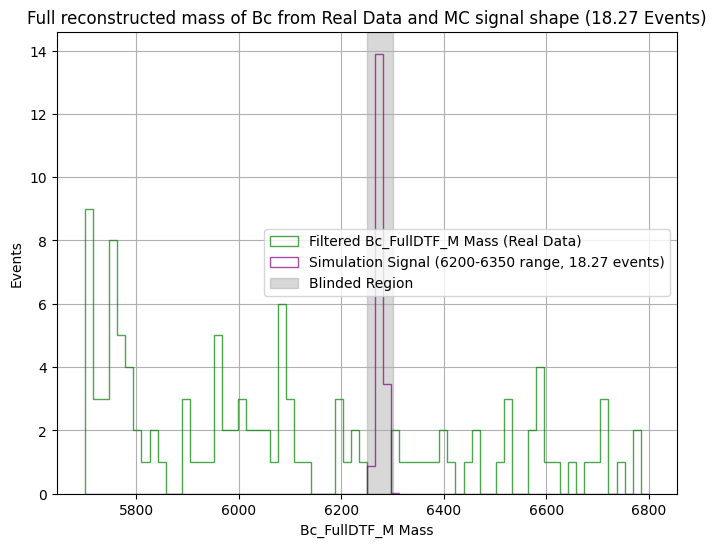

signal events: 18.27


In [29]:
cut = 0.96
real_data_predictions = classif_list[1].predict_proba(X_real)[:, 1]
real_data_filtered = real_data[real_data_predictions > cut]

print(f"Not-filtered data size: {real_data.shape[0]}")
print(f"Filtered data size: {real_data_filtered.shape[0]}")

signal_range = (simu_data['Bc_FullDTF_M'] > 6250) & (simu_data['Bc_FullDTF_M'] < 6300)
simu_signal_in_range = simu_data['Bc_FullDTF_M'][signal_range]
true_ev = 21*0.87
simu_signal_sampled = np.random.choice(simu_signal_in_range, size=15, replace=False)
scaling_factor = true_ev/len(simu_signal_in_range)

plt.figure(figsize=(8, 6))

# plt.hist(real_data['Bc_FullDTF_M'], range = (5700, 6800), bins=70, alpha=0.7, color='red', label="Original Bc_FullDTF_M Mass (Real Data)", histtype='step')
plt.hist(real_data_filtered['Bc_FullDTF_M'], range = (5700, 6800), bins=70, alpha=0.7, color='green', label="Filtered Bc_FullDTF_M Mass (Real Data)", histtype='step')
plt.hist(simu_signal_in_range, range = (5700, 6800), bins=70, alpha=0.7, color='purple', label=f"Simulation Signal (6200-6350 range, {true_ev} events)", histtype='step', weights=(np.ones_like(simu_signal_in_range) * scaling_factor))
plt.axvspan(6250, 6300, color="gray", alpha=0.3, label="Blinded Region")
plt.xlabel("Bc_FullDTF_M Mass")
plt.ylabel("Events")
plt.title(f"Full reconstructed mass of Bc from Real Data and MC signal shape ({true_ev} Events)")
plt.legend()
plt.grid(True)
plt.show()

print(f"signal events: {true_ev}")